In [39]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.geodesic import Geodesic
land_color = [85/255, 92/255, 105/255]
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=land_color)
plt.rcParams['axes.grid'] = True
import numpy as np
import xarray as xr
import pandas as pd
import gsw, os
etopo = xr.open_dataset('/home1/datawork/kbalem/ETOPO1_Bed_g_gmt4.nc')
gebco = xr.open_dataset('/home1/datawork/kbalem/GEBCO_2019.nc')

### Load GDAC index

In [2]:
ix = pd.read_csv('/home/ref-argo/gdac/ar_index_global_prof.txt', 
                 sep=',', index_col=None, header=0, skiprows=8,
                 names=['file','date','latitude','longitude','ocean','profiler_type','institution','update'], 
                 dtype={'file': np.unicode_, 'latitude': np.float32, 'longitude': np.float32, 'ocean': str, 'profiler_type': str, 'institution': str}
                )
ix.tail()

,file,date,latitude,longitude,ocean,profiler_type,institution,update
2897624,nmdis/2901633/profiles/R2901633_067.nc,2.013050e+13,27.462000,139.106995,P,841,NM,20130507103443
2897625,nmdis/2901633/profiles/R2901633_068.nc,2.013051e+13,27.431999,138.839996,P,841,NM,20130511165723
2897626,nmdis/2901633/profiles/R2901633_069.nc,2.013052e+13,27.691999,138.677002,P,841,NM,20130521170139
2897627,nmdis/2901633/profiles/R2901633_070.nc,2.013053e+13,27.895000,138.464996,P,841,NM,20130531181516
2897628,nmdis/2901633/profiles/R2901633_071.nc,2.013061e+13,27.931000,138.089996,P,841,NM,20130617181801


### deep subset & dac/wmo generation

In [3]:
ixs = ix[(ix['profiler_type']=='838')]

ixs = ixs.reset_index().drop(columns='index')
# parse the date after the subset, much more fast than inside the pd.read_csv()
ixs['date']= pd.to_datetime(ixs['date'],format='%Y%m%d%H%M%S')
# period of interest [datemin, datemax]
poi = np.array(['2000-01-01','2023-11-30'],dtype='datetime64')
ixs = ixs[(ixs['date']>=poi[0])&(ixs['date']<=poi[1])].reset_index()

# dac generation
dacs = {'AO':'aoml','BO':'bodc','IF':'coriolis','HZ':'csio','CS':'csiro','IN':'incois','JA':'jma','KM':'kma','KO':'kordi','ME':'meds','NM':'nmdis'}
ixs['wmo']=[int(f.split('/')[1]) for f in ixs['file']]
ixs['dac']=[dacs[f] for f in ixs['institution']]
ixs = ixs.groupby('wmo').last().reset_index()
ixs.tail()

,wmo,index,file,date,latitude,longitude,ocean,profiler_type,institution,update,dac
120,6903872,8737,coriolis/6903872/profiles/R6903872_090.nc,2023-11-28 11:18:00,61.070999,-39.436001,A,838,IF,20231128122857,coriolis
121,6903873,8827,coriolis/6903873/profiles/R6903873_089.nc,2023-11-20 07:02:00,49.098999,-42.205002,A,838,IF,20231120083126,coriolis
122,6990538,8845,coriolis/6990538/profiles/R6990538_016.nc,2023-11-22 00:06:00,53.640999,-26.841999,A,838,IF,20231122012547,coriolis
123,7901036,8862,coriolis/7901036/profiles/R7901036_015.nc,2023-11-22 16:09:00,59.508999,-48.191002,A,838,IF,20231122172659,coriolis
124,7901037,8879,coriolis/7901037/profiles/R7901037_015.nc,2023-11-21 18:15:00,58.676998,-41.412998,A,838,IF,20231121192657,coriolis


### Grounding detection
Here we load profile & traj file for each profile, then we check for groundings in the traj file. If there are any groundings occuring during the descent to profile depth, we get the grounding depth & date from the traj file, as well as the profile position,depth & date from the profile file.

In [4]:
urlt="/home/ref-argo/gdac/dac/coriolis/7901037/7901037_Rtraj.nc"   
dt = xr.open_dataset(urlt)
cycles_grounded = np.argwhere(np.isin(dt['GROUNDED'].values.astype(str),['Y'])).T[0]
cycles_grounded

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [6]:
dg = dt[['CYCLE_NUMBER','JULD','PRES']].where(dt['MEASUREMENT_CODE']==901.,drop=True).groupby('CYCLE_NUMBER').last()
park_end = dt[['CYCLE_NUMBER','JULD']].where(dt['MEASUREMENT_CODE']==300.,drop=True)
a = [(dg['JULD'][i].values - park_end['JULD'].where(park_end['CYCLE_NUMBER']==dg['CYCLE_NUMBER'][i],drop=True).values).astype(int)>0 
     for i in range(len(dg['CYCLE_NUMBER'].values))]
a = [a[i][0] for i in range(len(dg['CYCLE_NUMBER'].values))]
dg['grd_on_prf'] = xr.DataArray(a, dims=['CYCLE_NUMBER'])
dg = dg.where(dg['grd_on_prf']==True,drop=True)
dg

<xarray.Dataset>
Dimensions:       (CYCLE_NUMBER: 15)
Coordinates:
  * CYCLE_NUMBER  (CYCLE_NUMBER) float64 1.0 3.0 4.0 5.0 ... 13.0 14.0 15.0 16.0
Data variables:
    JULD          (CYCLE_NUMBER) datetime64[ns] 2023-07-04T09:57:00 ... 2023-...
    PRES          (CYCLE_NUMBER) float32 3.063e+03 2.978e+03 ... 3.141e+03
    grd_on_prf    (CYCLE_NUMBER) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    title:                        Argo float trajectory file
    institution:                  CORIOLIS
    source:                       Argo float
    history:                      2023-11-08T14:58:10Z creation; 2023-12-01T2...
    references:                   http://www.argodatamgt.org/Documentation
    user_manual_version:          3.4
    Conventions:                  Argo-3.2 CF-1.6
    featureType:                  trajectory
    decoder_version:              CODA_059c
    id:                           https://doi.org/10.17882/42182
    comment_on_resolution:        JULD and PRES variable resolutions depend o...
    comment_on_measurement_code:  Meaning of some specific measurement codes ...

In [14]:
d590 = dt[['CYCLE_NUMBER','JULD','PRES','LATITUDE','LONGITUDE']].where(dt['MEASUREMENT_CODE']==590.,drop=True).groupby('CYCLE_NUMBER').first()
d590 = d590.sel(CYCLE_NUMBER = dg['CYCLE_NUMBER'].values)
d703 = dt[['CYCLE_NUMBER','JULD','PRES','LATITUDE','LONGITUDE']].where(dt['MEASUREMENT_CODE']==703.,drop=True).groupby('CYCLE_NUMBER').first()
d703 = d703.sel(CYCLE_NUMBER = dg['CYCLE_NUMBER'].values)

In [15]:
d590['Z'] = -1*xr.DataArray(gsw.z_from_p(d590['PRES'],d703['LATITUDE']),dims='CYCLE_NUMBER')
dg['Z'] = -1*xr.DataArray(gsw.z_from_p(dg['PRES'],d703['LATITUDE']),dims='CYCLE_NUMBER')

In [22]:
dtmp = xr.Dataset({"LATITUDE":("N_GRD",d703['LATITUDE'].values),
                   "LONGITUDE":("N_GRD",d703['LONGITUDE'].values),
                   "PROFILER_TYPE":("N_GRD",np.repeat(838,len(d703['LATITUDE'].values))),
                   "CYCLE_NUMBER":("N_GRD",dg['CYCLE_NUMBER'].values),
                   "WMO":("N_GRD",np.zeros_like(d703['LONGITUDE'].values.astype(int))+7901037),
                   "GROUNDING_DEPTH": ("N_GRD",dg['Z'].values),
                   "PROFILE_DEPTH": ("N_GRD",d590['Z'].values),
                   "GROUNDING_DATE": ("N_GRD",dg['JULD'].values),
                   "PROFILE_DATE": ("N_GRD",d703['JULD'].values)},coords={})

In [23]:
dtmp

<xarray.Dataset>
Dimensions:          (N_GRD: 15)
Dimensions without coordinates: N_GRD
Data variables:
    LATITUDE         (N_GRD) float64 59.59 59.55 59.37 ... 57.99 58.68 57.99
    LONGITUDE        (N_GRD) float64 -38.56 -39.09 -38.07 ... -41.41 -43.8
    PROFILER_TYPE    (N_GRD) int64 838 838 838 838 838 ... 838 838 838 838 838
    CYCLE_NUMBER     (N_GRD) float64 1.0 3.0 4.0 5.0 6.0 ... 13.0 14.0 15.0 16.0
    WMO              (N_GRD) int64 7901037 7901037 7901037 ... 7901037 7901037
    GROUNDING_DEPTH  (N_GRD) float64 3.012e+03 2.929e+03 ... 3.033e+03 3.089e+03
    PROFILE_DEPTH    (N_GRD) float64 3.012e+03 2.929e+03 ... 3.033e+03 3.088e+03
    GROUNDING_DATE   (N_GRD) datetime64[ns] 2023-07-04T09:57:00 ... 2023-12-0...
    PROFILE_DATE     (N_GRD) datetime64[ns] 2023-07-04T20:01:35.999995392 ......

### 1. Grounding during descent to profile (most common)

In [25]:
# HARD MODE, SKIP IF ANY ISSUE
# INIT DS OUT
df1 = xr.Dataset({"LATITUDE":(["N_GRD"],[]),"LONGITUDE": (["N_GRD"],[]),"PROFILER_TYPE": (["N_GRD"],[]),"CYCLE_NUMBER": (["N_GRD"],[]),
                 "WMO": (["N_GRD"],np.array([],dtype='int')),"GROUNDING_DEPTH": (["N_GRD"],[]), 
                 "PROFILE_DEPTH": (["N_GRD"],[]),"GROUNDING_DATE": (["N_GRD"],np.array([],dtype='datetime64[ns]')),
                 "PROFILE_DATE": (["N_GRD"],np.array([],dtype='datetime64[ns]'))},coords={})

for i in range(len(ixs)):    
    #gen path
    urlt="/home/ref-argo/gdac/dac/"+ixs['dac'][i]+"/"+str(ixs['wmo'][i])+"/"+str(ixs['wmo'][i])+"_Rtraj.nc"       
    #check for traj file
    if (os.path.exists(urlt)):
        try:            
            dt = xr.open_dataset(urlt)        
            # Check if there's any grounding with the GROUNDED variable
            cycles_grounded = np.argwhere(np.isin(dt['GROUNDED'].values.astype(str),['Y'])).T[0]
            #grounded = dt['CYCLE_NUMBER_INDEX'].values[cycles_grounded]            
        except:            
            pass
        # IF there's any ...
        if (len(cycles_grounded)>0):            
            try:
                dg = dt[['CYCLE_NUMBER','JULD','PRES']].where(dt['MEASUREMENT_CODE']==901.,drop=True).groupby('CYCLE_NUMBER').last()                
                # Here we make sure that grounding occurs in the descent to profile depth and not during parking drift. We do that comparing grounding time 
                # (meas code 901) and parking drift end (meas code 300)
                park_end = dt[['CYCLE_NUMBER','JULD']].where(dt['MEASUREMENT_CODE']==300.,drop=True)
                a = [(dg['JULD'][i].values - park_end['JULD'].where(park_end['CYCLE_NUMBER']==dg['CYCLE_NUMBER'][i],drop=True).values).astype(int)>0 
                     for i in range(len(dg['CYCLE_NUMBER'].values))]
                a = [a[i][0] for i in range(len(dg['CYCLE_NUMBER'].values))]
                dg['grd_on_prf'] = xr.DataArray(a, dims=['CYCLE_NUMBER'])
                dg = dg.where(dg['grd_on_prf']==True,drop=True)
                                
                # PROFILE DATA : 590, start of profile, 703 : first irridium fix
                d590 = dt[['CYCLE_NUMBER','JULD','PRES','LATITUDE','LONGITUDE']].where(dt['MEASUREMENT_CODE']==590.,drop=True).groupby('CYCLE_NUMBER').first()
                d590 = d590.sel(CYCLE_NUMBER = dg['CYCLE_NUMBER'].values)
                d703 = dt[['CYCLE_NUMBER','JULD','PRES','LATITUDE','LONGITUDE']].where(dt['MEASUREMENT_CODE']==703.,drop=True).groupby('CYCLE_NUMBER').first()
                d703 = d703.sel(CYCLE_NUMBER = dg['CYCLE_NUMBER'].values)
                
                # MAX PRES AND DEPTH CALCULATION for ds and dg                
                d590['Z'] = -1*xr.DataArray(gsw.z_from_p(d590['PRES'],d703['LATITUDE']),dims='CYCLE_NUMBER')
                dg['Z'] = -1*xr.DataArray(gsw.z_from_p(dg['PRES'],d703['LATITUDE']),dims='CYCLE_NUMBER')                
                
                dtmp = xr.Dataset({"LATITUDE":("N_GRD",d703['LATITUDE'].values),
                                   "LONGITUDE":("N_GRD",d703['LONGITUDE'].values),
                                   "PROFILER_TYPE":("N_GRD",np.repeat(int(ixs['profiler_type'][i]),len(d703['LATITUDE'].values))),
                                   "CYCLE_NUMBER":("N_GRD",dg['CYCLE_NUMBER'].values),
                                   "WMO":("N_GRD",np.zeros_like(d703['LONGITUDE'].values.astype(int))+int(ixs['wmo'][i])),
                                   "GROUNDING_DEPTH": ("N_GRD",dg['Z'].values),
                                   "PROFILE_DEPTH": ("N_GRD",d590['Z'].values),
                                   "GROUNDING_DATE": ("N_GRD",dg['JULD'].values),
                                   "PROFILE_DATE": ("N_GRD",d703['JULD'].values)},coords={})
                    
                df1=xr.concat([df1,dtmp],dim='N_GRD')
            except:
                #print('issue on : '+urld) 
                pass
#SORT
df1 = df1.sortby('PROFILE_DATE')
#BAD DATA
df1 = df1.where(~df1['GROUNDING_DEPTH'].isnull(),drop=True)

In [28]:
df1

<xarray.Dataset>
Dimensions:          (N_GRD: 3929)
Dimensions without coordinates: N_GRD
Data variables:
    LATITUDE         (N_GRD) float64 47.23 47.33 47.29 ... 50.77 35.61 72.16
    LONGITUDE        (N_GRD) float64 -8.311 -8.415 -8.444 ... -16.16 -0.4657
    PROFILER_TYPE    (N_GRD) float64 838.0 838.0 838.0 ... 838.0 838.0 838.0
    CYCLE_NUMBER     (N_GRD) float64 80.0 81.0 83.0 85.0 ... 121.0 105.0 123.0
    WMO              (N_GRD) float64 6.902e+06 6.902e+06 ... 6.903e+06 6.904e+06
    GROUNDING_DEPTH  (N_GRD) float64 3.148e+03 2.714e+03 ... 3.223e+03 2.245e+03
    PROFILE_DEPTH    (N_GRD) float64 3.152e+03 2.713e+03 ... 3.224e+03 2.241e+03
    GROUNDING_DATE   (N_GRD) datetime64[ns] 2014-07-16T16:27:00 ... 2023-12-0...
    PROFILE_DATE     (N_GRD) datetime64[ns] 2014-07-17T07:12:10 ... 2023-12-0...

In [26]:
df1.to_netcdf('grd_descent_to_profiles.nc')

In [2]:
#df1 = xr.open_dataset('grd_descent_to_profiles.nc')

In [29]:
## ADD BATHY
for df in [df1]:
    # SPREAD BATHY : Array of random points around position to interpolate bathy
    # INIT at 100m around points
    PTS=np.array([np.asarray(Geodesic().circle(lon=df['LONGITUDE'].isel(N_GRD=i).values,
                                               lat=df['LATITUDE'].isel(N_GRD=i).values,
                                               radius=100.,
                                               n_samples=25)) for i in range(len(df['N_GRD']))])
    # SPREAD 200-2000m around points
    radius = 2000.0 #in meters
    radrange  = np.linspace(200,radius,10)
    for r in radrange:
        PT0=np.array([np.asarray(Geodesic().circle(lon=df['LONGITUDE'].isel(N_GRD=i).values,
                                                   lat=df['LATITUDE'].isel(N_GRD=i).values,
                                                   radius=r,
                                                   n_samples=50)) for i in range(len(df['N_GRD']))])
        PTS = np.column_stack((PTS,PT0))

    x=xr.DataArray(PTS[:,:,0],dims=['N_GRD','PTS'])
    y=xr.DataArray(PTS[:,:,1],dims=['N_GRD','PTS'])
    spread_bathy = xr.Dataset()
    spread_bathy['etopo'] = -1*etopo.interp(x=x,y=y,method='linear')['z']
    spread_bathy['gebco'] = -1*gebco.interp(lon=x,lat=y,method='linear')['elevation']
    df['etopo_min'] = spread_bathy['etopo'].min('PTS')
    df['etopo_max'] = spread_bathy['etopo'].max('PTS')
    df['gebco_min'] = spread_bathy['gebco'].min('PTS')
    df['gebco_max'] = spread_bathy['gebco'].max('PTS')

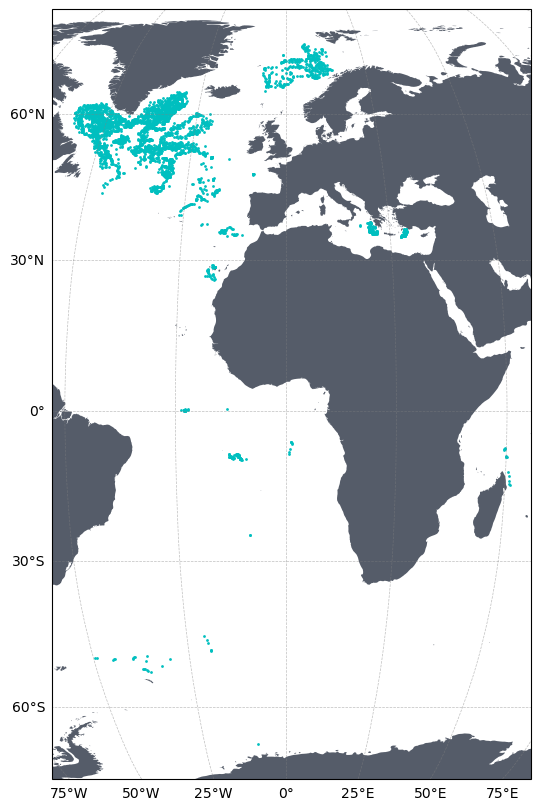

In [57]:
fig=plt.figure(figsize=(12,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.add_feature(land_feature, edgecolor=None)

ax.plot(df1['LONGITUDE'],df1['LATITUDE'],'.c', markersize=4, markeredgecolor='None', alpha=1, transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

In [34]:
import scipy.stats as stats
x=df1['GROUNDING_DEPTH'].values
y=((df1['etopo_min']+df1['etopo_max'])/2).values
yb=((df1['gebco_min']+df1['gebco_max'])/2).values
res = stats.linregress(x, yb)

Text(0, 0.5, 'ABathy [m]')

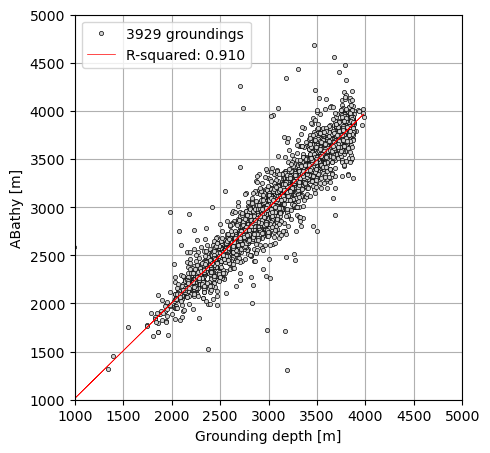

In [58]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(x,y,'o',label=f"{len(x)} groundings", color='lightgrey', markersize=3, markeredgecolor='k', markeredgewidth=0.5)
#a=ax.scatter(x,y,s=4,c=df1['N_PROF'])
#plt.colorbar(a)
plt.plot(x, res.intercept + res.slope*x, 'r',linewidth=0.5,label=f"R-squared: {res.rvalue**2:.3f}")
ax.set_xlim([1000,5000])
ax.set_ylim([1000,5000])
ax.legend()
ax.set_xlabel('Grounding depth [m]')
ax.set_ylabel('ABathy [m]')
#fig.savefig('groundingVsBathy.png')

## USE CASE 1

In [59]:
dfu1 = df1.where((((df1['etopo_min']+df1['etopo_max'])/2)<1500) & (df1['GROUNDING_DEPTH']>3000),drop=True)

In [80]:
print(dfu1.gebco_min.values,dfu1.gebco_max.values)

[1313.31292477] [1371.5931302]


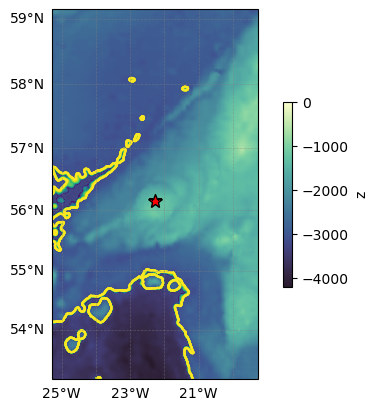

In [90]:
fig=plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.add_feature(land_feature, edgecolor=None)

etopo.where((etopo['x']>dfu1['LONGITUDE'].values-3)&(etopo['x']<dfu1['LONGITUDE'].values+3)&(etopo['y']>dfu1['LATITUDE'].values-3)&(etopo['y']<dfu1['LATITUDE'].values+3),
            drop=True)['z'].plot(vmax=0,cmap=cmocean.cm.deep_r, cbar_kwargs={'shrink': 0.5},ax=ax, transform=ccrs.PlateCarree())
etopo.where((etopo['x']>dfu1['LONGITUDE'].values-3)&(etopo['x']<dfu1['LONGITUDE'].values+3)&(etopo['y']>dfu1['LATITUDE'].values-3)&(etopo['y']<dfu1['LATITUDE'].values+3),
            drop=True)['z'].plot.contour(x='x',y='y',levels=np.arange(-3200,-3150),ax=ax, transform=ccrs.PlateCarree())

ax.plot(dfu1['LONGITUDE'],dfu1['LATITUDE'],'*r', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

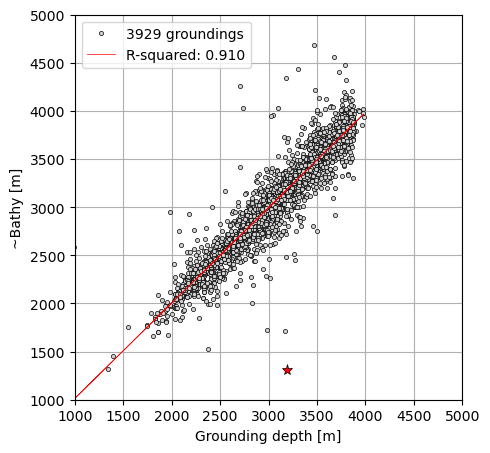

In [91]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(x,y,'o',label=f"{len(x)} groundings", color='lightgrey', markersize=3, markeredgecolor='k', markeredgewidth=0.5)
ax.plot(x, res.intercept + res.slope*x, 'r',linewidth=0.5,label=f"R-squared: {res.rvalue**2:.3f}")
ax.set_xlim([1000,5000])
ax.set_ylim([1000,5000])
ax.legend()
ax.set_xlabel('Grounding depth [m]')
ax.set_ylabel('~Bathy [m]')

ax.plot(dfu1['GROUNDING_DEPTH'],((dfu1['etopo_min']+dfu1['etopo_max'])/2),'*',color='red', markersize=8, markeredgecolor='k', markeredgewidth=0.5)

In [61]:
print(dfu1.WMO.values,dfu1.GROUNDING_DATE.values,dfu1.GROUNDING_DEPTH.values,dfu1.CYCLE_NUMBER.values)

[6903082.] ['2021-12-15T09:03:00.000000000'] [3187.02076049] [19.]


In [62]:
#GET DESCENT RATE FOR THAT GROUNDING ?
dt = xr.open_dataset('/home/ref-argo/gdac/dac/coriolis/6903082/6903082_Rtraj.nc',engine='argo')

In [63]:
descent = dt[['CYCLE_NUMBER','JULD','PRES','LATITUDE','LONGITUDE']].where((dt['MEASUREMENT_CODE']==389.)&(dt['CYCLE_NUMBER']==19),drop=True)
descent

<xarray.Dataset>
Dimensions:       (N_MEASUREMENT: 6)
Dimensions without coordinates: N_MEASUREMENT
Data variables:
    CYCLE_NUMBER  (N_MEASUREMENT) float64 19.0 19.0 19.0 19.0 19.0 19.0
    JULD          (N_MEASUREMENT) datetime64[ns] 2021-12-15T05:53:00 ... 2021...
    PRES          (N_MEASUREMENT) float32 2.786e+03 2.838e+03 ... 3.241e+03
    LATITUDE      (N_MEASUREMENT) float64 nan nan nan nan nan nan
    LONGITUDE     (N_MEASUREMENT) float64 nan nan nan nan nan nan
Attributes:
    title:                        Argo float trajectory file
    institution:                  CORIOLIS
    source:                       Argo float
    history:                      2021-09-28T10:01:07Z creation; 2023-11-25T1...
    references:                   http://www.argodatamgt.org/Documentation
    user_manual_version:          3.4
    Conventions:                  Argo-3.2 CF-1.6
    featureType:                  trajectory
    decoder_version:              CODA_058i
    id:                           https://doi.org/10.17882/42182
    comment_on_resolution:        JULD and PRES variable resolutions depend o...
    comment_on_measurement_code:  Meaning of some specific measurement codes ...

In [101]:
descent

<xarray.Dataset>
Dimensions:       (N_MEASUREMENT: 6)
Dimensions without coordinates: N_MEASUREMENT
Data variables:
    CYCLE_NUMBER  (N_MEASUREMENT) float64 19.0 19.0 19.0 19.0 19.0 19.0
    JULD          (N_MEASUREMENT) datetime64[ns] 2021-12-15T05:53:00 ... 2021...
    PRES          (N_MEASUREMENT) float32 2.786e+03 2.838e+03 ... 3.241e+03
    LATITUDE      (N_MEASUREMENT) float64 nan nan nan nan nan nan
    LONGITUDE     (N_MEASUREMENT) float64 nan nan nan nan nan nan
    DP            (N_MEASUREMENT) float32 52.0 145.5 201.0 82.0 0.5 0.0
Attributes:
    title:                        Argo float trajectory file
    institution:                  CORIOLIS
    source:                       Argo float
    history:                      2021-09-28T10:01:07Z creation; 2023-11-25T1...
    references:                   http://www.argodatamgt.org/Documentation
    user_manual_version:          3.4
    Conventions:                  Argo-3.2 CF-1.6
    featureType:                  trajectory
    decoder_version:              CODA_058i
    id:                           https://doi.org/10.17882/42182
    comment_on_resolution:        JULD and PRES variable resolutions depend o...
    comment_on_measurement_code:  Meaning of some specific measurement codes ...

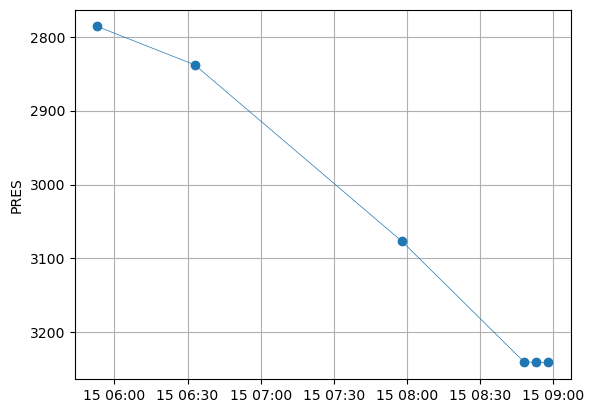

In [120]:
fig,ax = plt.subplots(1,1)
#plt.plot(descent['JULD'],descent['PRES'].differentiate('N_MEASUREMENT'),'-x',linewidth=0.5)
plt.plot(descent['JULD'],descent['PRES'],'-o',linewidth=0.5)
plt.gca().invert_yaxis()
plt.ylabel('PRES')
plt.savefig('6903082_19/descent.png')